In this project, we will utilize pandas to analyze data, including value, risk, and return metrics, of the prominent 'FAANG' companies: Facebook, Apple, Amazon, Netflix, and Google. We will address several questions in this notebook:

1. What was the change in our stocks' prices over time?
2. What were the moving averages of our stocks?
3. What were the daily return averages of each stock?
4. What was the correlation between the daily returns of different stocks?
5. How much value do we put at risk by investing in a particular stock?
6. How can we attempt to predict future 'FAANG' stock behavior?

In [14]:
from __future__ import division
import pandas as pd
from pandas import Series,DataFrame
import numpy as np

#Visualisation imports
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

from datetime import datetime
#Using yfinance to access Yahoo Historical Stocks
import yfinance as yf

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

We will compare the five "FAANG" companies to analyze their average stock prices and returns. Our objective is to perform a risk assessment of the stocks in the last 365 days.

In [15]:
tickers = ['AAPL','GOOG','MSFT','AMZN','NFLX']

current_time = datetime.now()

# Date one year prior to current
one_year_prior = datetime(current_time.year-1,current_time.month,current_time.day) 

ticker_data = {}
for ticker in tickers:
    ticker_data[ticker] = yf.download(ticker,one_year_prior,current_time)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Here, we have compiled simple statistics regarding the stock price of Netflix in the previous year.

## Tech Stock Analysis: Price, Volume, Moving Averages, and Daily Return Visualization

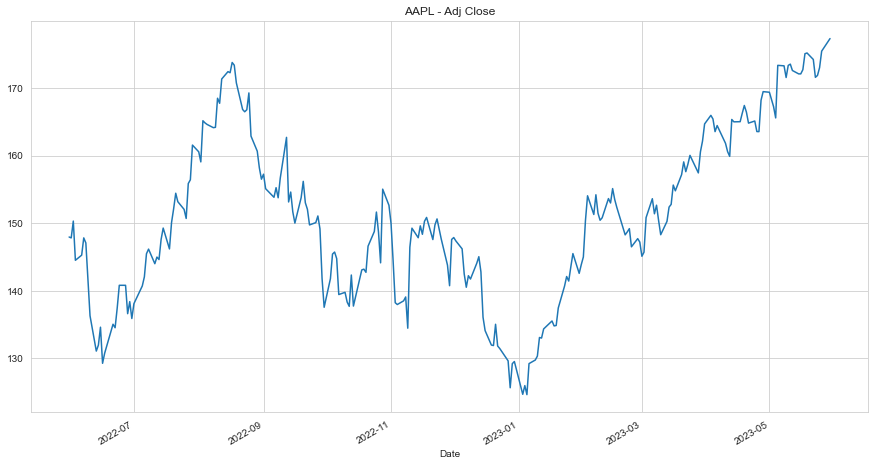

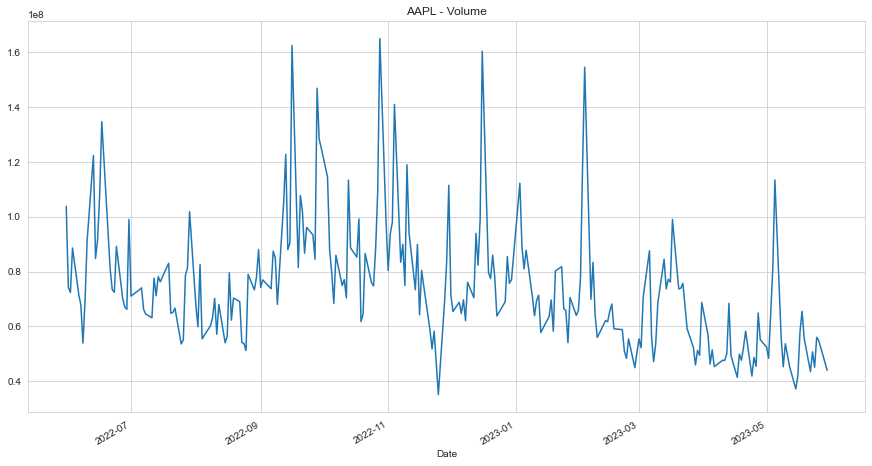

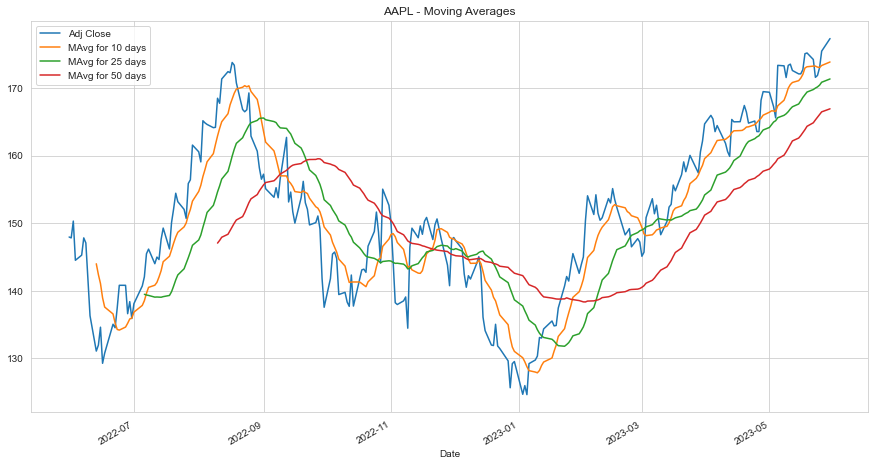

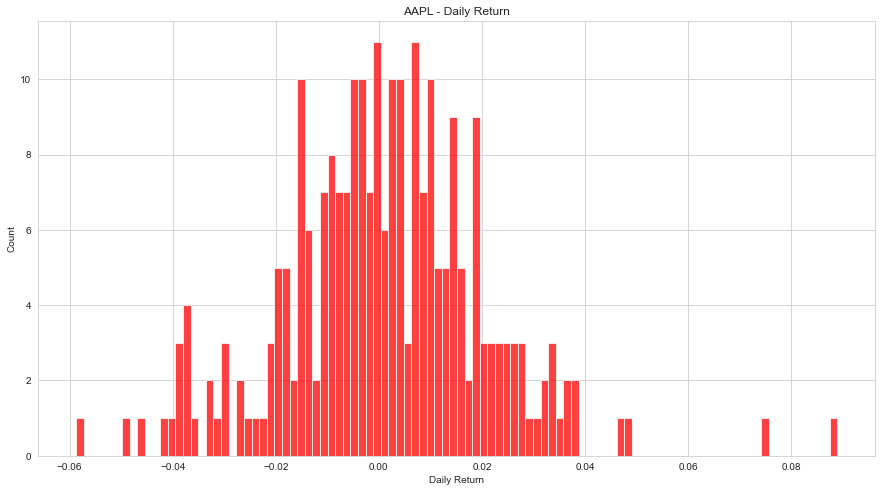

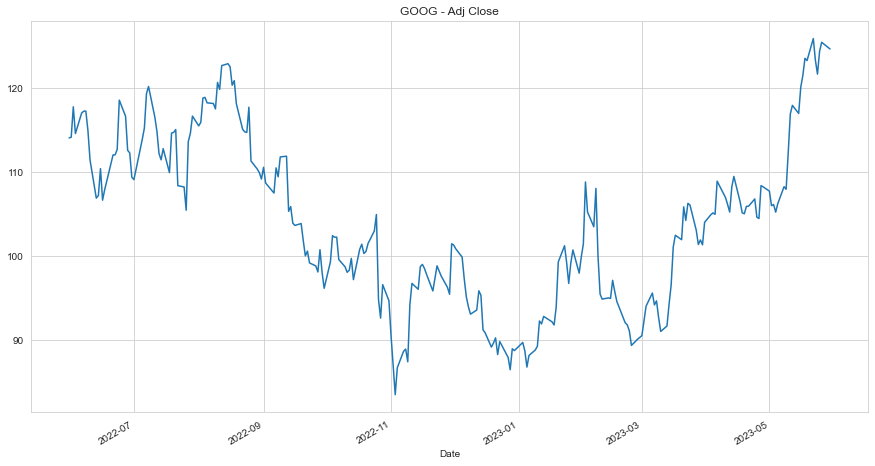

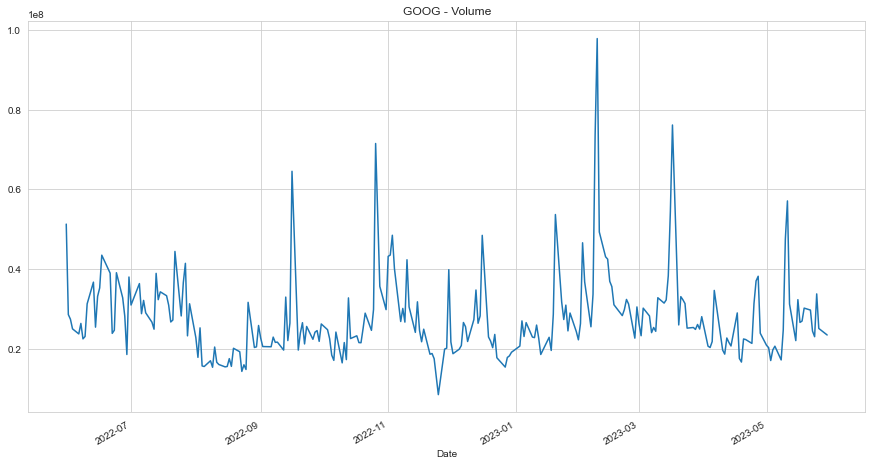

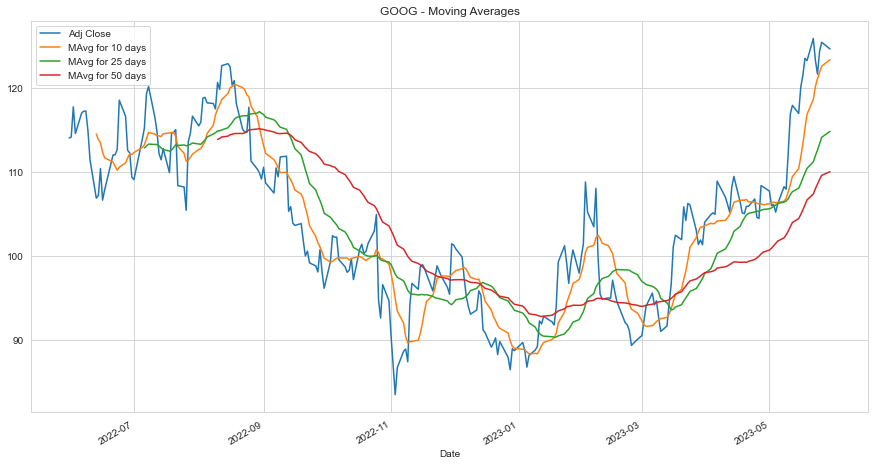

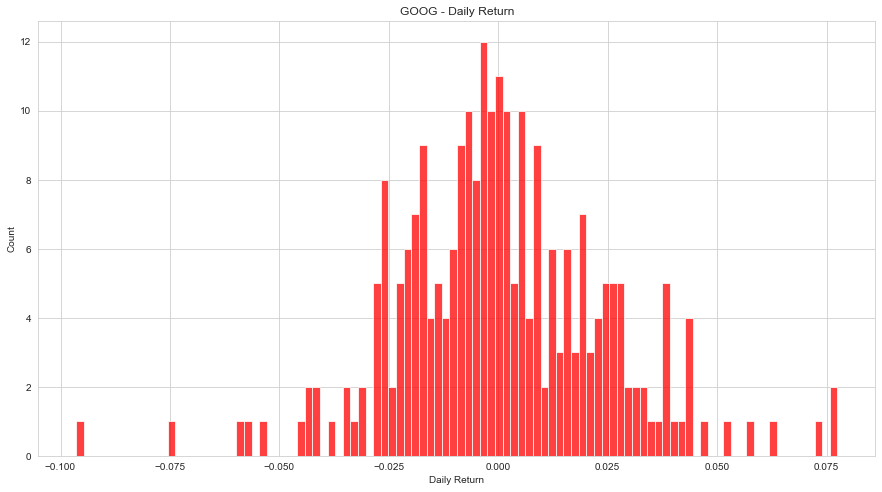

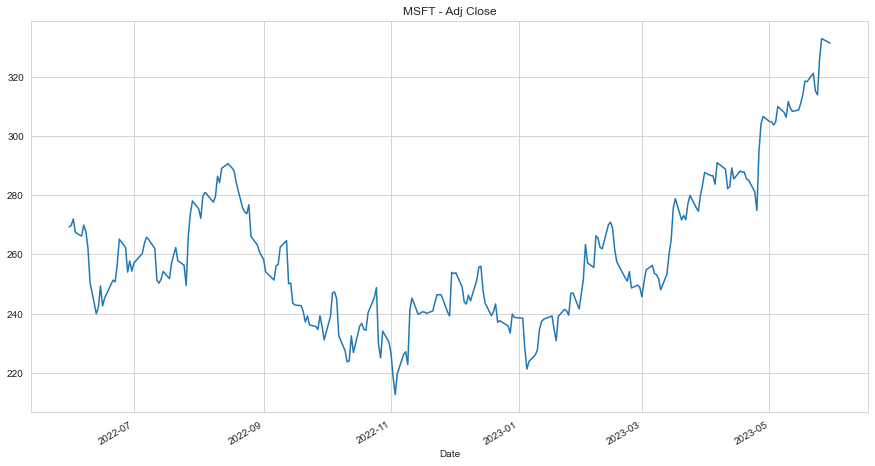

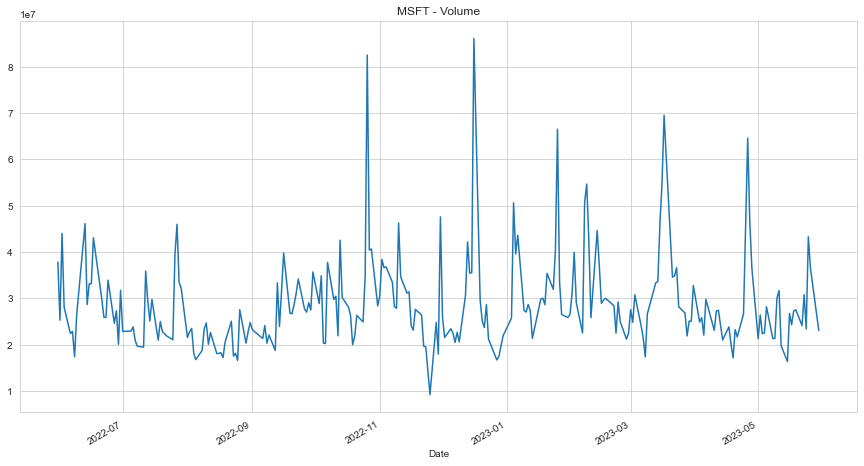

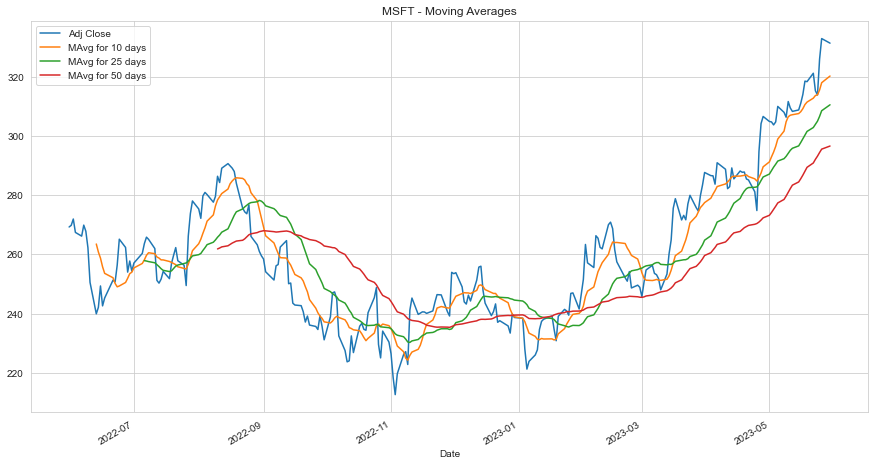

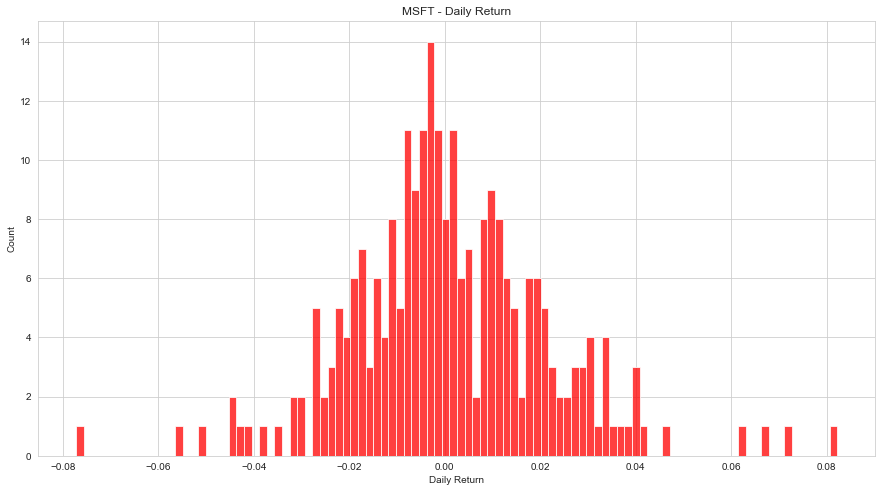

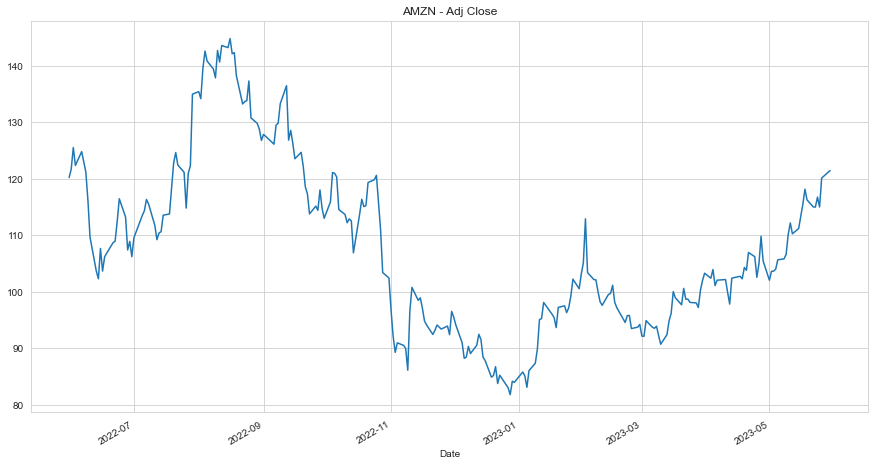

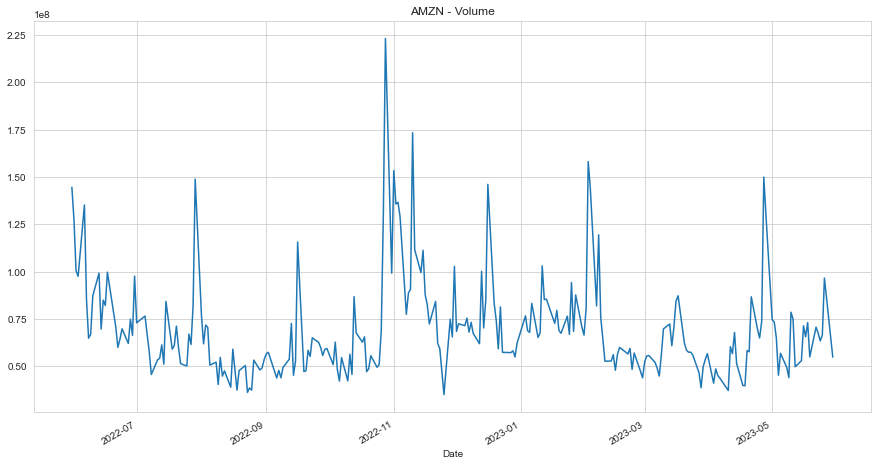

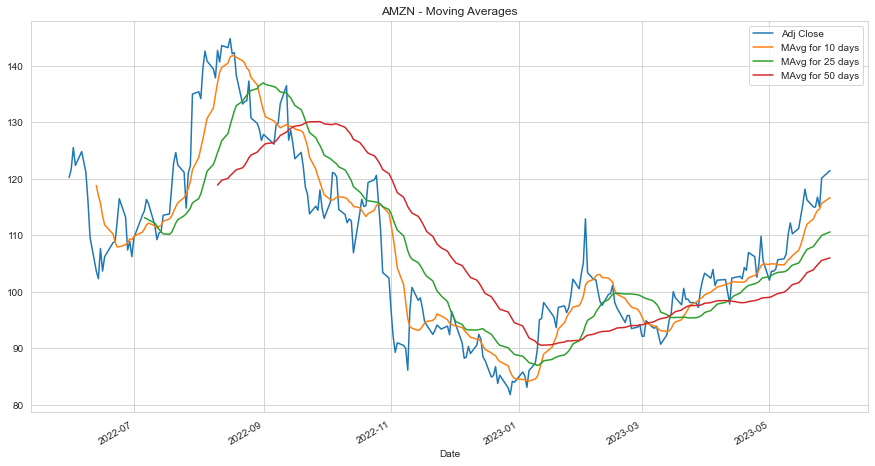

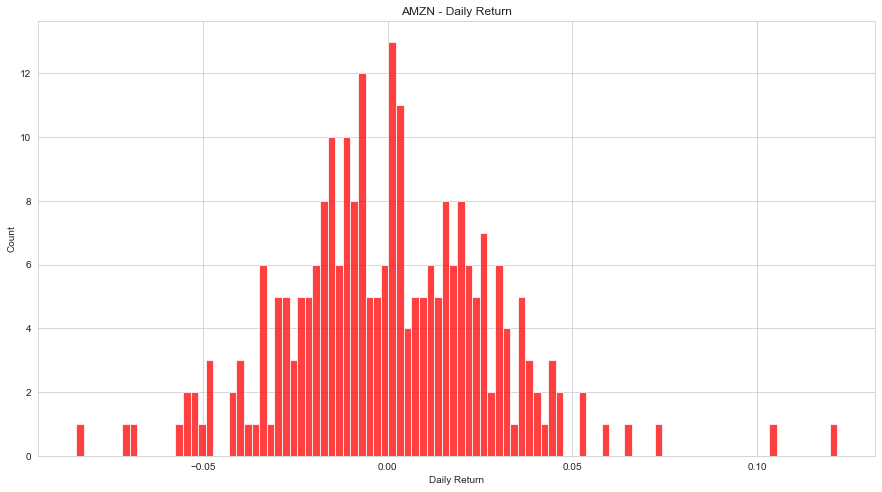

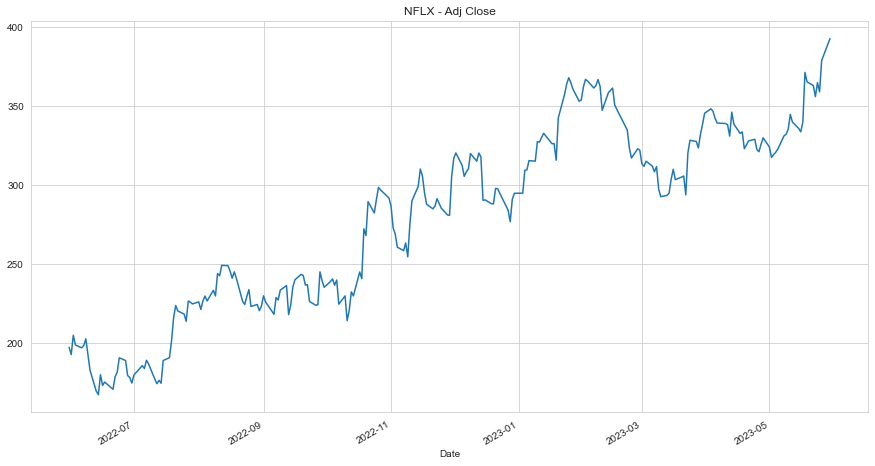

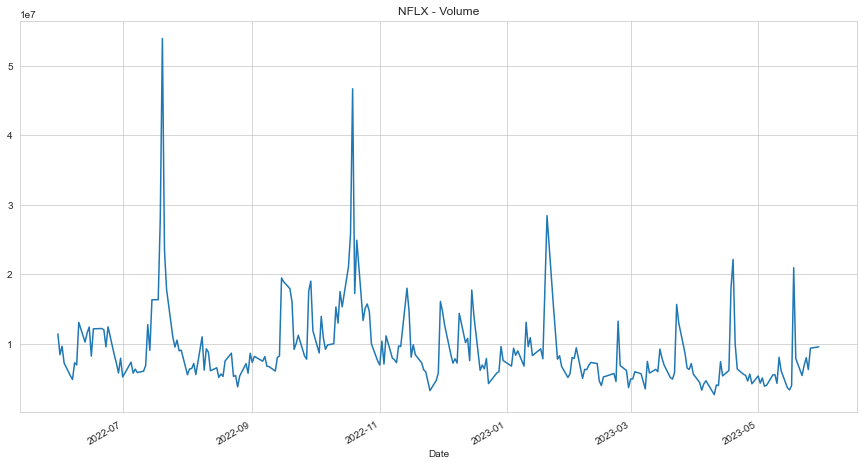

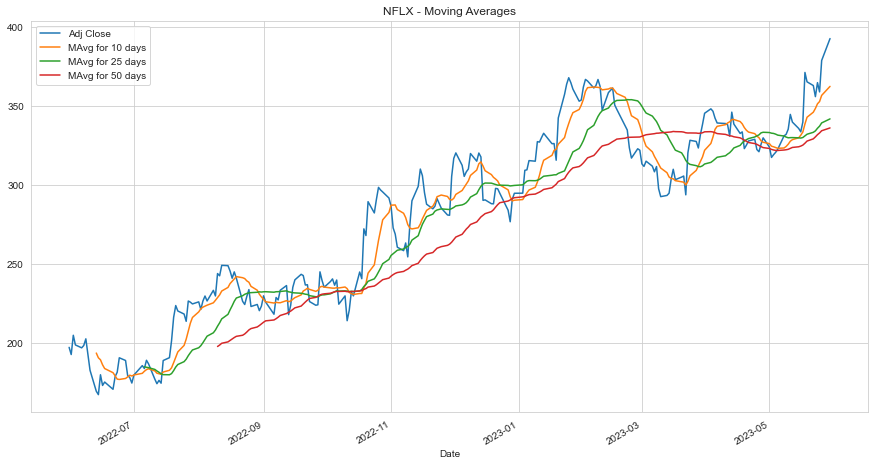

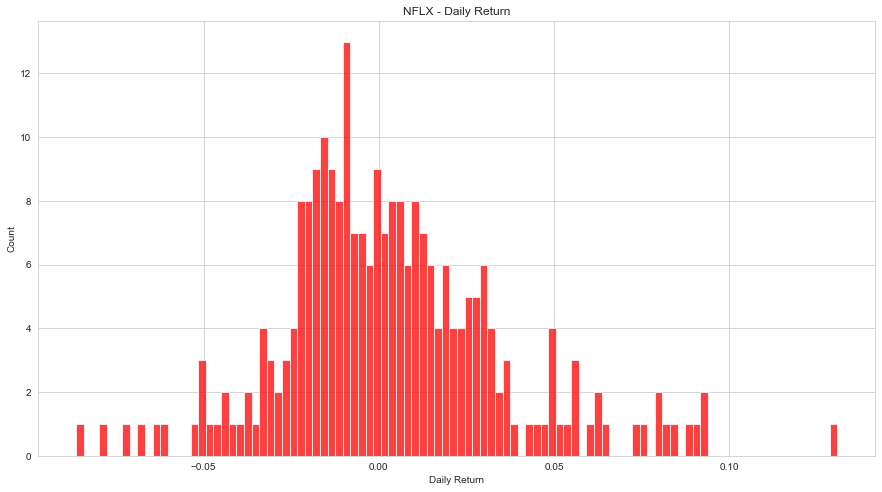

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of averages
averages = [10,25,50]

# Loop through each stock's dataframe
for ticker, df in ticker_data.items():

    # Plot 'Adj Close'
    plt.figure(figsize=(15,8))
    df['Adj Close'].plot()
    plt.title(f'{ticker} - Adj Close')
    plt.show()

    # Plot 'Volume'
    plt.figure(figsize=(15,8))
    df['Volume'].plot()
    plt.title(f'{ticker} - Volume')
    plt.show()

    # Compute moving averages and plot them
    for avg in averages:
        label = f"MAvg for {avg} days"
        df[label] = df['Adj Close'].rolling(window=avg, center=False).mean()

    df[['Adj Close', 'MAvg for 10 days', 'MAvg for 25 days', 'MAvg for 50 days']].plot(figsize=(15,8))
    plt.title(f'{ticker} - Moving Averages')
    plt.show()

    # Compute daily return
    df['Daily Return'] = df['Adj Close'].pct_change()

    # Plot 'Daily Return'
    plt.figure(figsize=(15,8))
    sns.histplot(df['Daily Return'].dropna(), bins=100, color='red')
    plt.title(f'{ticker} - Daily Return')
    plt.show()

In [18]:
rets_compr = pd.DataFrame()

for ticker in ticker_data:
    rets_compr[ticker] = ticker_data[ticker]['Adj Close'].pct_change()


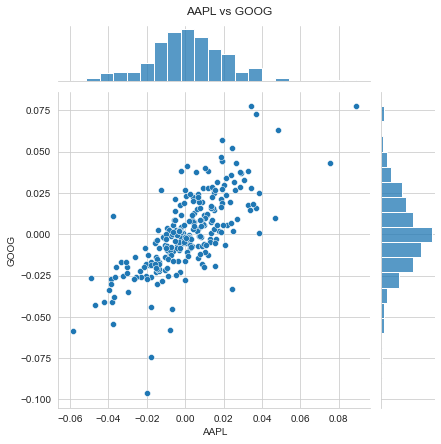

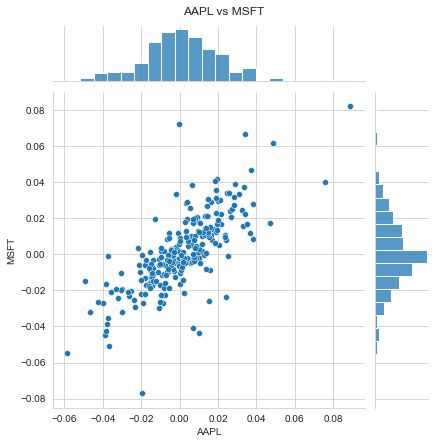

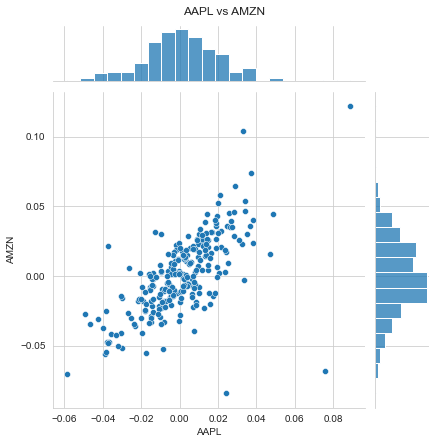

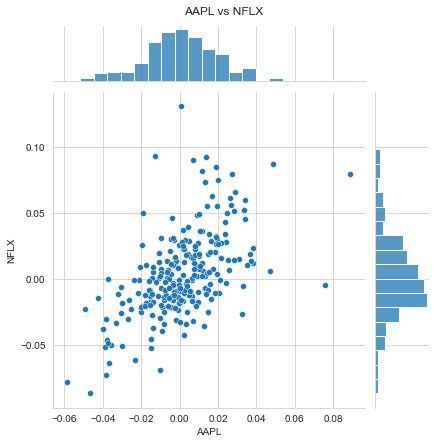

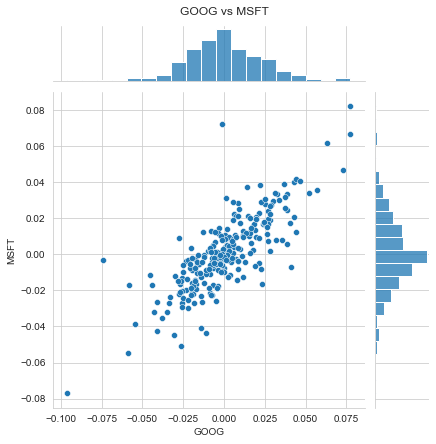

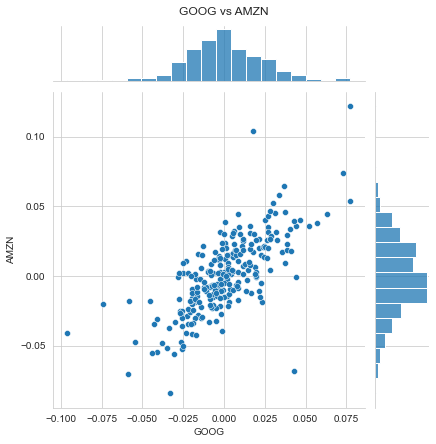

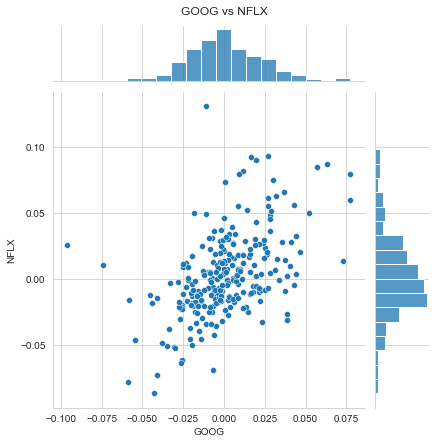

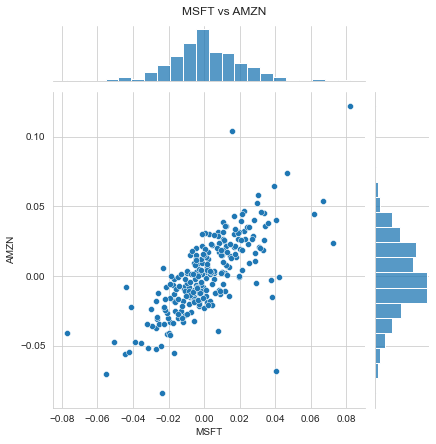

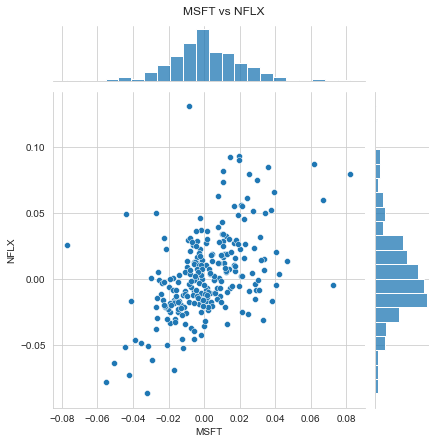

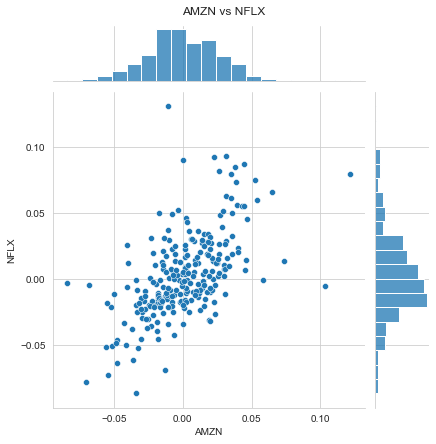

In [19]:
# Assuming rets_compr is the dataframe where you stored the daily returns
for i in range(len(tickers)):
    for j in range(i+1, len(tickers)):
        sns.jointplot(x=tickers[i], y=tickers[j], data=rets_compr, kind='scatter')
        plt.suptitle(f'{tickers[i]} vs {tickers[j]}', y=1.02)
        plt.show()

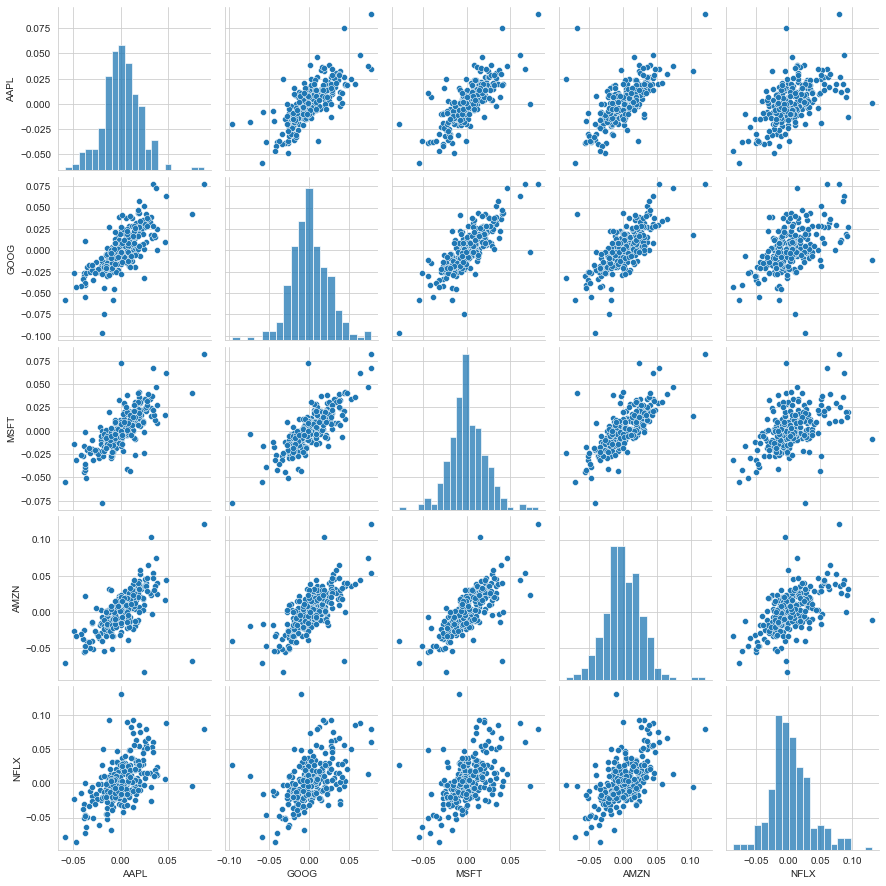

In [20]:
sns.pairplot(rets_compr.dropna())

          AAPL      GOOG      MSFT      AMZN      NFLX
AAPL  1.000000  0.729176  0.751210  0.669211  0.562940
GOOG  0.729176  1.000000  0.797277  0.723076  0.509433
MSFT  0.751210  0.797277  1.000000  0.734920  0.494960
AMZN  0.669211  0.723076  0.734920  1.000000  0.581125
NFLX  0.562940  0.509433  0.494960  0.581125  1.000000


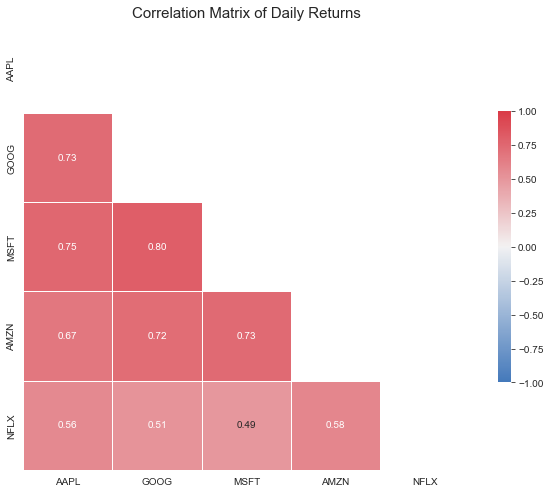

In [21]:
# Assuming rets_compr is the dataframe where you stored the daily returns
correlation_matrix = rets_compr.corr()
print(correlation_matrix)

# Create a mask to only show the lower triangle of the matrix
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Initialize matplotlib figure
fig, ax = plt.subplots(figsize=(10, 10))

# Create a custom diverging colormap
cmap = sns.diverging_palette(250, 10, as_cmap=True)

# Draw the heatmap
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f")

plt.title('Correlation Matrix of Daily Returns', fontsize=15)
plt.show()


## Random Forest to Predict Adj Close 

In [35]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

# For each stock
for ticker, df in ticker_data.items():
    
    # Create x and y
    x = df.iloc[:, 0:5].values
    y = df.iloc[:, 4].values

    # Split the data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30,  random_state=0)

    # Scale the data using MinMaxScaler
    scaler = MinMaxScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    # Initialize and fit the model
    randomForestModel = RandomForestRegressor(n_estimators=500, random_state=42, min_samples_split=2, min_samples_leaf=1, max_depth=10, bootstrap=True)
    randomForestModel.fit(x_train, y_train)

    # Predict the stock prices
    predict = randomForestModel.predict(x_test)

    # Print metrics
    print(f"{ticker} Predictions:")
    print(f'Accuracy: {round(100 - np.mean(100 * (abs(predict - y_test) / y_test)), 2)} %.')

AAPL Predictions:
Accuracy: 99.81 %.
GOOG Predictions:
Accuracy: 99.84 %.
MSFT Predictions:
Accuracy: 99.78 %.
AMZN Predictions:
Accuracy: 99.76 %.
NFLX Predictions:
Accuracy: 99.65 %.


## SVM to Predict Adj Close

In [36]:
from sklearn.svm import SVR

# For each stock
for ticker, df in ticker_data.items():
    
    # Create x and y
    x = df.iloc[:, 0:5].values
    y = df.iloc[:, 4].values

    # Split the data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30,  random_state=0)

    # Scale the data using MinMaxScaler
    scaler = MinMaxScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    # Initialize and fit the model
    SVRmodel = SVR(kernel = 'rbf')
    SVRmodel.fit(x_train, y_train)

    # Predict the stock prices
    predict = SVRmodel.predict(x_test)

    # Print metrics
    print(f"{ticker} Predictions:")
    print(f'Accuracy: {round(100 - np.mean(100 * (abs(predict - y_test) / y_test)), 2)} %.')

AAPL Predictions:
Accuracy: 99.29 %.
------------------------------------------------------------------------------ 
GOOG Predictions:
Accuracy: 99.4 %.
------------------------------------------------------------------------------ 
MSFT Predictions:
Accuracy: 98.0 %.
------------------------------------------------------------------------------ 
AMZN Predictions:
Accuracy: 98.8 %.
------------------------------------------------------------------------------ 
NFLX Predictions:
Accuracy: 94.66 %.
------------------------------------------------------------------------------ 


## KNeighborsRegressor to Predict Adj Close

In [37]:
from sklearn.neighbors import KNeighborsRegressor

# For each stock
for ticker, df in ticker_data.items():

    # Create x and y
    x = df.iloc[:, 0:5].values
    y = df.iloc[:, 4].values

    # Split the data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30,  random_state=0)

    # Scale the data using MinMaxScaler
    scaler = MinMaxScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    # Initialize and fit the model
    neigh = KNeighborsRegressor(n_neighbors=2)
    neigh.fit(x_train, y_train)

    # Predict the stock prices
    predict = neigh.predict(x_test)

    # Print metrics
    print(f"{ticker} Predictions:")
    print(f'Accuracy: {round(100 - np.mean(100 * (abs(predict - y_test) / y_test)), 2)} %.')

AAPL Predictions:
Accuracy: 99.67 %.
GOOG Predictions:
Accuracy: 99.65 %.
MSFT Predictions:
Accuracy: 99.61 %.
AMZN Predictions:
Accuracy: 99.53 %.
NFLX Predictions:
Accuracy: 99.49 %.


## Gradient Boosting to Predict Adj Close

In [38]:
from sklearn.ensemble import GradientBoostingRegressor

# For each stock
for ticker, df in ticker_data.items():

    # Create x and y
    x = df.iloc[:, 0:5].values
    y = df.iloc[:, 4].values

    # Split the data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30,  random_state=0)

    # Scale the data using MinMaxScaler
    scaler = MinMaxScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    # Initialize and fit the model
    gb_regressor = GradientBoostingRegressor()
    gb_regressor.fit(x_train, y_train)

    # Predict the stock prices
    predict = gb_regressor.predict(x_test)

    # Print metrics
    print(f"{ticker} Predictions:")
    print(f'Accuracy: {round(100 - np.mean(100 * (abs(predict - y_test) / y_test)), 2)} %.')

AAPL Predictions:
Accuracy: 99.88 %.
GOOG Predictions:
Accuracy: 99.86 %.
MSFT Predictions:
Accuracy: 99.79 %.
AMZN Predictions:
Accuracy: 99.81 %.
NFLX Predictions:
Accuracy: 99.68 %.


## LSTM to predict Adj Close

In [40]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define tickers
tickers = ['AAPL', 'GOOG', 'MSFT', 'AMZN', 'NFLX']

# For each stock
for ticker in tickers:
    # Get stock data
    df = ticker_data[ticker]

    # Create x and y
    x = df.iloc[:, 0:5].values
    y = df.iloc[:, 4].values

    # Split the data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=0)

    # Scale the data using MinMaxScaler
    scaler = MinMaxScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    # Reshape the data for LSTM
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the LSTM model
    model.fit(x_train, y_train, epochs=50, batch_size=32)

    # Make predictions
    lstm_predictions = model.predict(x_test)

    # Print metrics
    accuracy = 100 - np.mean(100 * (abs(lstm_predictions - y_test) / y_test))
    print(f"{ticker} Predictions:")
    print(f"Accuracy: {round(accuracy, 2)}%")


Epoch 1/50
6/6 [==============================] - 4s 8ms/step - loss: 23037.4551
Epoch 2/50
6/6 [==============================] - 0s 7ms/step - loss: 22981.1484
Epoch 3/50
6/6 [==============================] - 0s 7ms/step - loss: 22893.4629
Epoch 4/50
6/6 [==============================] - 0s 8ms/step - loss: 22729.4668
Epoch 5/50
6/6 [==============================] - 0s 8ms/step - loss: 22420.6738
Epoch 6/50
6/6 [==============================] - 0s 10ms/step - loss: 21862.3828
Epoch 7/50
6/6 [==============================] - 0s 10ms/step - loss: 21141.3438
Epoch 8/50
6/6 [==============================] - 0s 7ms/step - loss: 20493.0352
Epoch 9/50
6/6 [==============================] - 0s 8ms/step - loss: 20065.5391
Epoch 10/50
6/6 [==============================] - 0s 6ms/step - loss: 19810.3809
Epoch 11/50
6/6 [==============================] - 0s 6ms/step - loss: 19634.2520
Epoch 12/50
6/6 [==============================] - 0s 7ms/step - loss: 19490.5742
Epoch 13/50
6/6 [======

## Comparison of different approaches

From the correlation heatmap, it becomes clear that Microsoft and Amazon share a stronger correlation, and in general
Microsoft maintains a strongest pairwise aggregate correlations compared to the rest of the 'FAANG' companies. Though perhaps expected, it is noteworthy that all five companies pairwise have moderate to strong positive correlation.

## Determining Value from Risk vs. Expected Return
Now we address the question of risk in buying stocks to compare these five companies.

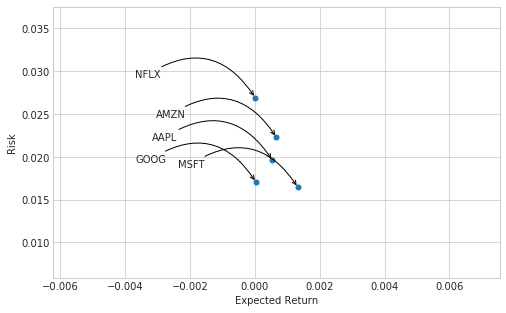

In [61]:
rets_filled = rets_compr.dropna()
plt.figure(figsize=(8,5))

plt.scatter(rets_filled.mean(),rets_filled.std(),s=25)

plt.xlabel('Expected Return')
plt.ylabel('Risk')

for label,x,y in zip(rets_filled.columns,rets_filled.mean(),rets_filled.std()):
    plt.annotate(
    label,
    xy=(x,y),xytext=(-120,20),
    textcoords = 'offset points',
    arrowprops = dict(arrowstyle='->',connectionstyle = 'arc3,rad=-0.5'))

From this plot we can see that Microsoft has the highest expected return and the lowest risk -- a sign that it is the best stock to buy at the moment. With its overhaul of its cloud computing sectors and high-profile acquisitions, Microsoft stock is a clear winner here. Netflix's performance is more concerning as it has virtually zero positive expected return along with the highest risk.

We want to model an additional value-at-risk metric in order to assess the value at each risk confidence interval for these 5 companies. Let's try this two ways: bootstrapping and using Monte Carlo-GBM, with Google.

In [67]:
rets_compr.head()

,AAPL,AMZN,GOOG,MSFT,NFLX
Date,,,,,
2018-07-16,NaN,NaN,NaN,NaN,NaN
2018-07-17,0.002818,0.011764,0.012620,0.009978,-0.052437
2018-07-18,-0.005462,-0.000548,-0.002436,-0.007865,-0.011463
2018-07-19,0.007731,-0.016251,-0.007459,-0.006864,-0.029057
2018-07-20,-0.002275,0.000403,-0.001727,0.017911,-0.008731


In [70]:
rets_compr['GOOG'].quantile(q=0.05)


-0.02652993944252803

In [71]:
rets_compr['GOOG'].quantile(q=0.01)



-0.05042288804732199

From the empirical quantiles given for both confience intervals, we know that the worst possible loss will not exceed 2.65 percent with 95% confidence and 5.04 percent with 99% confidence.

## Predicting Future Risk and Value of Stocks
We run the Monte Carlo Method on the GBM model to assess the stability and predict the future risk of our stocks. For this component, I'll be analyzing Google's stock.

In [ ]:
days = 365

#delta t
dt = 1/365

mu = rets_compr.mean()['GOOG']

sigma = rets_compr.std()['GOOG']


def stock_monte_carlo(start_price,days,mu,sigma):
    
    price = np.zeros(days)
    price[0] = start_price
    
    shock = np.zeros(days)
    drift = np.zeros(days)
    
    for x in range(1,days):
        
        #Shock and drift formulas taken from the Monte Carlo formula
        shock[x] = np.random.normal(loc=mu*dt,scale=sigma*np.sqrt(dt))
        
        drift[x] = mu * dt
        
        #New price = Old price + Old price*(shock+drift)
        price[x] = price[x-1] + (price[x-1] * (drift[x]+shock[x]))
        
    return price


We’re going to run 100 Monte Carlo simulations of Google stocks. Here's the stock's opening values again.



In [ ]:
GOOG.head()

In [ ]:
start_price = 1189.39 #Taken from above

for run in range(1,100):
    plt.plot(stock_monte_carlo(start_price,days,mu,sigma))

plt.xlabel('Days')
plt.ylabel('Price')
plt.title('Monte Carlo Analysis for Google')

In [ ]:
runs = 10000

simulations = np.zeros(runs)

for run in range(1,runs):
    simulations[run] = stock_monte_carlo(start_price,days,mu,sigma)[days-1]
q = np.percentile(simulations,1)

plt.hist(simulations,bins=200,range = [1100,1300])

plt.figtext(0.6,0.8,s="Start price: $%.2f" %start_price)

plt.figtext(0.6,0.7,"Mean final price: $%.2f" % simulations.mean())

plt.figtext(0.6,0.6,"VaR(0.99): $%.2f" % (start_price -q,))

plt.figtext(0.15,0.6, "q(0.99): $%.2f" % q)

plt.axvline(x=q, linewidth=4, color='r')

plt.title(u"Final price distribution for Google Stock after %s days" %days, weight='bold')

Based off the histogram, we conclude that Google's stock price is very stable (only a $0.11 difference between start and mean final price). The value-at-risk of our investment is $46.42 for maximum low price of $1142.97 with 99% confidence, which is approximately a 3.9% risk compared to the 6.5% we achieved via bootstrapping. 